In [1]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("nbAgg") # Have to first change to a different backend in order to get the classes to reload on the next line.
# mpl.use("module://ipympl.backend_nbagg")
# mpl.use("module://" + __name__)

mpl.get_backend()

'module://matplotlib_inline.backend_inline'

In [2]:
# from typing import TypeVar

# def testFn(a : TypeVar[T], b) -> T:
#     return a

In [3]:
# Target: Bar color demo
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_colors.html#sphx-glr-gallery-lines-bars-and-markers-bar-colors-py

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()

# fruits = ['apple', 'blueberry', 'cherry', 'orange']
# counts = [40, 100, 30, 55]
# bar_labels = ['red', 'blue', '_red', 'orange']
# bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

# ax.bar(fruits, counts, label=bar_labels, color=bar_colors)

# ax.set_ylabel('fruit supply')
# ax.set_title('Fruit supply by kind and color')
# ax.legend(title='Fruit color')

# plt.show()

In [2]:
execfile("snp.py")
do_inference(open("current_notebook.py").read())
# fig, ax = plt.subplots()
# text = ax.set_title("My Plot", loc="center")
# xs = np.linspace(0, 2 * np.pi, 20)
# ys = np.sin(xs)
# lines = ax.plot(ys)
# # ax.yaxis.set_label_text("Units")

# start = time.monotonic_ns()
# tag_with_paths_deep(fig, "fig", mypy_result.graph)
# tag_with_paths_deep(ax, "ax", mypy_result.graph)
# print((time.monotonic_ns() - start) / 1e9)

current_notebook.py:34: error: Name "execfile" is not defined  [name-defined]
current_notebook.py:35: error: Name "do_inference" is not defined  [name-defined]
current_notebook.py:64: error: Name "SNP" is not defined  [name-defined]
current_notebook.py:64: error: Name "mypy_result" is not defined  [name-defined]
current_notebook.py:64: error: Name "re" is not defined  [name-defined]
current_notebook.py:64: error: Name "IPython" is not defined  [name-defined]


[{'call': {'loc': {'line': 10, 'column': 0, 'end_line': 10, 'end_column': 17}},
  'callee': {'.class': 'CallableType',
   'arg_types': [],
   'arg_kinds': [],
   'arg_names': [],
   'ret_type': 'builtins.str',
   'fallback': 'builtins.function',
   'name': 'get_backend',
   'variables': [],
   'is_ellipsis_args': False,
   'implicit': False,
   'bound_args': [],
   'def_extras': {'first_arg': None},
   'type_guard': None,
   'from_concatenate': False,
   'unpack_kwargs': False,
   'loc': {'line': 10, 'column': 0, 'end_line': 10, 'end_column': 15}},
  'given_args': []},
 {'call': {'loc': {'line': 35,
    'column': 13,
    'end_line': 35,
    'end_column': 47}},
  'callee': {'.class': 'CallableType',
   'arg_types': ['io.TextIOBase',
    {'.class': 'UnionType',
     'items': ['builtins.int', {'.class': 'NoneType'}]}],
   'arg_kinds': [0, 1],
   'arg_names': ['self', None],
   'ret_type': 'builtins.str',
   'fallback': 'builtins.function',
   'name': 'read of TextIOBase',
   'variables': 

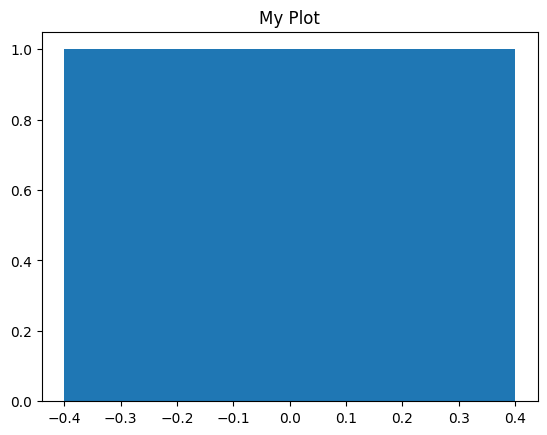

current_notebook.py:34: error: Name "execfile" is not defined  [name-defined]
current_notebook.py:35: error: Name "do_inference" is not defined  [name-defined]
current_notebook.py:64: error: Name "SNP" is not defined  [name-defined]
current_notebook.py:64: error: Name "mypy_result" is not defined  [name-defined]
current_notebook.py:64: error: Name "re" is not defined  [name-defined]
current_notebook.py:64: error: Name "IPython" is not defined  [name-defined]
current_notebook.py:34: error: Name "execfile" is not defined  [name-defined]
current_notebook.py:35: error: Name "do_inference" is not defined  [name-defined]
current_notebook.py:64: error: Name "SNP" is not defined  [name-defined]
current_notebook.py:64: error: Name "mypy_result" is not defined  [name-defined]
current_notebook.py:64: error: Name "re" is not defined  [name-defined]
current_notebook.py:64: error: Name "IPython" is not defined  [name-defined]
current_notebook.py:34: error: Name "execfile" is not defined  [name-defin

In [268]:
# mpl.use("module://matplotlib_inline.backend_inline")
plt.ioff()
fig, ax = plt.subplots()

fruits = ['apple', 'blueberry', 'cherry', 'orange']
counts = [40, 100, 30, 55]
# bar_labels = ['red', 'blue', '_red', 'orange']
# bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
# ax.bar(fruits, counts, label=bar_labels, color=bar_colors)

# ax.set_ylabel('fruit supply')
# ax.set_title('Fruit supply by kind and color')
# ax.legend(title='Fruit color')
ax.set_title("My Plot")
# START HERE widget for ax.bar call is not great
ax.bar(0.0, 1.0)

SNP(fig, locals(), mypy_result.graph, user_names=set(re.compile(r'\b').split(IPython.get_ipython().history_manager.input_hist_raw[-1])))

In [352]:
# IPython.get_ipython().kernel.shell.ast_transformers = []
# ax.bar(fruits, counts)[0]

In [301]:
import mypy.subtypes

counts_type = mypy_result.graph["current_notebook"].tree.names["counts"].type

arraylike_type = mypy_result.graph["matplotlib.axes"].tree.names["Axes"].node.names["bar"].node.type.arg_types[1].items[1]

# START HERE: use subtyping to determine which locals to offer in dropdowns

( mypy.subtypes.is_subtype(counts_type, counts_type)
, mypy.subtypes.is_subtype(counts_type, arraylike_type)
, mypy.subtypes.is_subtype(arraylike_type, counts_type)
)


(1, 1, 0)

In [359]:
ax.containers[0].get_children()

In [8]:
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names['xaxis'].type.type.names
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names['xaxis'].type.type.direct_base_classes()[0].names
mypy_result.graph["current_notebook"].tree.names['ax'].type.type.names['xaxis'].type.type.direct_base_classes()[0].direct_base_classes()[0].names

mypy_result.graph["current_notebook"].tree.names['fig'].type.type.names['axes'].type

def (self: matplotlib.figure.Figure) -> builtins.list[matplotlib.axes._axes.Axes]

In [9]:
ax.yaxis.__class__ # matplotlib.axis.YAxis
mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.names
mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].type

def (self: matplotlib.axis.Axis, label: builtins.str, fontdict: builtins.dict[Any, Any] =, **kwargs: Any) -> Any

In [10]:
class A:
    class B:
        pass

mypy_result.graph["current_notebook"].tree.names["A"].node.names["B"].node

KeyError: 'A'

In [ ]:
ax.yaxis.__class__.__module__
ax.yaxis.__class__.__qualname__
ax.yaxis.__class__.__module__.split(".") + ax.yaxis.__class__.__qualname__.split(".")

In [ ]:
this_cell_code = IPython.get_ipython().history_manager.input_hist_raw[-1]

this_cell_tokens = set(re.compile(r'\b').split(this_cell_code))

stuff = locals()

for token in list(stuff):
    if token in this_cell_tokens:
        print(token, stuff[token])


In [ ]:

def object_names(locals):
    out = {}
    for name, value in [(name, value) for name, value in locals.items() if name not in trivial_names and not callable(value)]:
        key = id(value)
        out[key] = out.get(key, set()).union({name})
    return out

object_names(locals())


In [ ]:
sources, options = mypy.main.process_options([file_path])

# # options.incremental = True
# options.incremental = False
# # options.show_traceback = True
# options.preserve_asts = True
# options.strict_optional = True
# options.warn_unused_configs = True
# # options.fine_grained_incremental = True
# # options.use_fine_grained_cache = True
# options.mypy_path = ["python-type-stubs-main"]
# options.follow_imports = "silent"
# options.follow_imports_for_stubs = True
# options.export_types = True

options.incremental = True
# options.incremental = False
# options.show_traceback = True
options.preserve_asts = True
options.strict_optional = True
options.warn_unused_configs = True
options.fine_grained_incremental = True
options.use_fine_grained_cache = True
options.local_partial_types = True # https://github.com/python/mypy/issues/4492
options.mypy_path = ["python-type-stubs-main"]
options.follow_imports = "silent"
options.follow_imports_for_stubs = True
options.export_types = True

# print(options)
fscache = mypy.fscache.FileSystemCache() # IDK if this is needed
mypy_result = mypy.build.build(sources, options=options, fscache=fscache)

fine_grained_build_manager = mypy.server.update.FineGrainedBuildManager(mypy_result)

fine_grained_build_manager.update([(module_name, file_path)], [])
fine_grained_build_manager.flush_cache()
fscache.flush()


In [ ]:
{"a": "b" for k,v in [(1,2)]}

In [ ]:
[arg.initializer for arg in mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].type.definition.arguments]

mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].node.type.arg_kinds
mypy_result.graph["matplotlib.axis"].tree.names["YAxis"].node.direct_base_classes()[0].names["set_label_text"].type.def_extras

In [ ]:
x = object()

In [ ]:
x

In [ ]:
id(x)

In [ ]:
x = object()
y = object()
x == x

In [ ]:
def method_associations(artist):
    match artist:
        case mpl.axes.Axes() as ax:
            return [(ax.title, "set_title")]
        case mpl.axis.Axis() as axis:
            return [(axis.label, "set_label_text")]
        case _:
            return []



method_associations(ax.xaxis)